### Enron Fraud Case: Identifying Person of Interest (POI) using Machine Learning Tools

For this project, we utilize machine learning skills to choose a algorithm to identify Enron Employees who may have committed fraud based on the public Enron financial and email datasets. The approach to arrive at a best model include:

* handling real-world dataset: Since such dataset tends to be imperfect, we may have to clean and remove the data plus make some assumptions about the data inadequacies; 
* validating machine learning results using test data;
* evaluate machine learning result using quantitative metrics such as accuracy, precision, and recall scores;
* dealing with features: This includes creating, selecting, and transforming variables;
* comparing the performance of various machine learning algorithms
* fine tuning machine learning algorithms for maximum performance; and
* communicating your machine learning algorithm results clearly.

At the minimum, the best machine learning algorithm chose will have precision and recall scores of at least 0.3.


###### Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud due to misleading accounting practices. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

Using Machine Learning tools, we built a best model for a person of interest identifier based on financial and email data made public as a result of the Enron scandal. The dataset provided by Udacity has the persons of interest in the fraud case tagged, which is defined by individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

##### Analyses


In [174]:
# Base Packages & Path

import sys
import pickle
import matplotlib.pyplot
import tester
sys.path.append("../tools/")

import numpy as np
import pandas as pd

from feature_format import featureFormat, targetFeatureSplit

from tester import dump_classifier_and_data

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn import tree
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from tester import test_classifier
from time import time

***
__Task 1: Select what features you'll use__

In [175]:
### Task 1: Select what features you'll use. ###
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
### features_list = ['poi','salary'] # You will need to use more features
# data_label = 'poi'
# features_list = enron_tools.get_features(data_dict)

# features_list = ['poi','salary', 'expenses', 'total_stock_value', 'bonus', 'from_poi_to_this_person', 'shared_receipt_with_poi'] # You will need to use more features

features_financial = ['salary', 'deferral_payments', 'total_payments',
                      'loan_advances', 'bonus', 'restricted_stock_deferred', 
                      'deferred_income', 'total_stock_value', 'expenses', 
                      'exercised_stock_options', 'other', 
                      'long_term_incentive', 'restricted_stock', 
                      'director_fees']
                      
features_email = ['to_messages', 'email_address', 'from_poi_to_this_person', 
                  'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

# Removing email address - not likely to be useful
# due to missing emails, already have name, and categorical nature.
features_email.remove('email_address')

# Initial Fueature List for Analysis
features_list = ['poi'] + features_financial + features_email

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

###### Data Overview

*Important Dataset Characteristics*

The original data contains 146 observations with 21 features. Of these 146 observations, 128 observations were persons of interests (POI). With no missing value, 18 observations were non-POIs.

For our Machine Learning analyses, we focussed on three features: exercised_stock_options, bonus, and salary. We could have gone with more but we found out that additional features did not add much to the model, in terms of model performance. 

"NaN" issue is an issue in this dataset. Only 4 features have values for more than 75% of observations. Six of them have less than 50% missing values, i.e. loan_advances, director_fees, restricted_stock_deferred, deferral_payments, deferred_income, and long_term_incentive. For this project, we assumed these "NaN" values to be zero for simplicity. 

*Missing Values*

In research, missing values may not be the first thing we look into. After conducting a few analyses with the data, I noticed that the significant numbers of "NaN" values may pose a problem for the analysis. 

In this Machine Learning course, we did not go through the algorithm on how we arrived at the best fitting algorithm. However, based on what I know about regression, "NaN" or too many zero values would not be the most useful in arriving at a fitting model. So, my hypothesis is that variables with many NaN values would not be useful for precision and recall. Hopefully, *SelectKBest* will tell us if this is true. Besides *SelectKBest*, we need to be cognizant of not including variables that tend to be highly correlated - either via definition or correlation finding.



In [176]:
### Missing Value count helps to determine less useful variables
# Dataframe Table Format

enron_df = pd.DataFrame.from_dict(data_dict, orient = "index")
enron_df.replace(to_replace='NaN', value=np.nan, inplace=True)

enron_df.count().sort_values()

# Missing data is an issue if we want to use the data for analyses
# Are these NaNs missing values or non-inputted values, thus, they should be zero?

loan_advances                  4
director_fees                 17
restricted_stock_deferred     18
deferral_payments             39
deferred_income               49
long_term_incentive           66
bonus                         82
from_poi_to_this_person       86
to_messages                   86
shared_receipt_with_poi       86
from_this_person_to_poi       86
from_messages                 86
other                         93
salary                        95
expenses                      95
exercised_stock_options      102
restricted_stock             110
email_address                111
total_payments               125
total_stock_value            126
poi                          146
dtype: int64

The features are sorted by the number of valid response with the least numberof valied response listed the first. A question we need to address here is whether the "not a number" response here are actually zero or missing values. This is actually a huge portion of a project in real life, especially for a case of this magnitude. This approach is time consuming because we extensive research requirement. A simpler approach would be to impute these zero-or-missing values but things can easily get messy here too. Imputations introduce errors to the data if not performed well. For this study, we assume that these values are actually **zeroes**.

In [177]:
# Dataframe Table Format
enron_df = pd.DataFrame.from_dict(data_dict, orient = "index")

# Setting index name of pandas data frame to POI's name
enron_df.index.name = "Name"

# Removing Less Useful Column - Already Have Unique Name
enron_df.drop(["email_address"], inplace=True,axis=1)

#convert columns from objects to float
for c in enron_df.columns:
    if enron_df[c].dtype == object:
        enron_df[c] = enron_df[c].astype("float64")

**Which observations have the many missing values?**

In [178]:
### Missing Variables
enron_df["nmiss"] = enron_df.isnull().sum(axis = 1)
print(enron_df["nmiss"].describe())
print "Median=", (enron_df["nmiss"].median())

count    146.000000
mean       9.061644
std        4.296306
min        2.000000
25%        5.000000
50%        9.000000
75%       12.000000
max       19.000000
Name: nmiss, dtype: float64
Median= 9.0


In [179]:
# Let's Analyze Observation with so Many Missing Data
enron_df[enron_df["nmiss"]>15]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,nmiss
Name,,,,,,,,,,,,,,,,,,,,,
CHRISTODOULOU DIOMEDES,NaN,NaN,NaN,NaN,5127155.0,NaN,950730.0,NaN,NaN,6077885.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,16
CLINE KENNETH W,NaN,NaN,NaN,NaN,NaN,NaN,662086.0,NaN,-472568.0,189518.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,16
GILLIS JOHN,NaN,NaN,NaN,NaN,9803.0,NaN,75838.0,NaN,NaN,85641.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,16
GRAMM WENDY L,NaN,NaN,NaN,119292.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,119292.0,NaN,NaN,NaN,17
LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,19
SAVAGE FRANK,NaN,NaN,NaN,3750.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,125034.0,-121284.0,NaN,NaN,16
SCRIMSHAW MATTHEW,NaN,NaN,NaN,NaN,759557.0,NaN,NaN,NaN,NaN,759557.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,17
THE TRAVEL AGENCY IN THE PARK,NaN,NaN,NaN,362096.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,362096.0,NaN,False,NaN,NaN,NaN,NaN,17
WAKEHAM JOHN,NaN,NaN,NaN,213071.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,109298.0,NaN,NaN,NaN,16


We have one person with no meaningful data, so, we'll expunge **"LOCKHART EUGENE E"** from the dataset. I contemplated on removing the other observations with too many "NaN" values. 

I noticed that all of these individuals have NaN (zero?) income. They either had either  stocks or received director fees. Both of them may be useful in poi algorithm. So, we've decided to keep these observations. 

In [180]:
poi_count = pd.crosstab(index = enron_df["poi"],columns="count") 
poi_count

col_0,count
poi,
False,128
True,18


In [181]:
### Since describe produces freq and top=NaN, 
### convert 'NaN' from strings to a real 'NaN'
enron_df.replace(to_replace='NaN', value=np.nan, inplace=True)

data_point_orig = enron_df.shape[0]

print "Original Dataset Dimension:",enron_df.shape
print "Original Dataset Observations:",enron_df.shape[0]
print "Original Dataset Variables:",enron_df.shape[1]

print "\nUNIVARIATE STATISTICS"
enron_df.describe().transpose()
# enron_df.dtypes

Original Dataset Dimension: (146, 21)
Original Dataset Observations: 146
Original Dataset Variables: 21

UNIVARIATE STATISTICS


,count,mean,std,min,25%,50%,75%,max
salary,95.0,5.621943e+05,2.716369e+06,477.0,211816.00,259996.0,312117.00,26704229.0
to_messages,86.0,2.073860e+03,2.582701e+03,57.0,541.25,1211.0,2634.75,15149.0
deferral_payments,39.0,1.642674e+06,5.161930e+06,-102500.0,81573.00,227449.0,1002671.50,32083396.0
total_payments,125.0,5.081526e+06,2.906172e+07,148.0,394475.00,1101393.0,2093263.00,309886585.0
exercised_stock_options,102.0,5.987054e+06,3.106201e+07,3285.0,527886.25,1310813.5,2547724.00,311764000.0
bonus,82.0,2.374235e+06,1.071333e+07,70000.0,431250.00,769375.0,1200000.00,97343619.0
restricted_stock,110.0,2.321741e+06,1.251828e+07,-2604490.0,254018.00,451740.0,1002369.75,130322299.0
shared_receipt_with_poi,86.0,1.176465e+03,1.178318e+03,2.0,249.75,740.5,1888.25,5521.0
restricted_stock_deferred,18.0,1.664106e+05,4.201494e+06,-7576788.0,-389621.75,-146975.0,-75009.75,15456290.0
total_stock_value,126.0,6.773957e+06,3.895777e+07,-44093.0,494510.25,1102872.5,2949846.75,434509511.0


Univariate statistical analyses may tell us about bad data too. For example, we look into the data range. Data points thta fall outside an expected range shoudld be investigated. An obvious example is salary, which should be positive. 

My three immediate concerns pertain to *restricted stocks*, *restricted stock deferred*, and *total stocks* because these financial assets can take negative and positive values. Based on my limited knowledge on corporate finance, I can see how specific stocks may have negative values. People may have purchased stocks when their values were really high and sold them when their values were low - most likely at the *peak* of the scandal. In the end, I take all these values as accpetable and they are included in the analyses.

##### Other Data Explorations

In [182]:
# Typical Data Checks
# print "Dataframe dimension is", enron_df.shape
# print "\nName is the Index: \n",enron_df.index
# print "\nColumn Names: \n",enron_df.columns
# print "\nColumn Data Type: \n",enron_df.dtypes

***
__Task 2: Remove outliers and Other Bad Data__

##### Data Cleaning


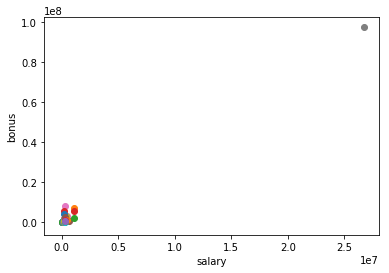

In [183]:
### read in data dictionary, convert to numpy array
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)

### Add these lines ... to make your scatterplot: 

for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

In [184]:
# Outlier Identification
# OLD: enron_df.loc[enron_df.salary>5000000]

enron_df.loc[enron_df.salary > \
            enron_df.salary.mean() + (3 * enron_df.salary.std())]

# enron_df.loc['THE TRAVEL AGENCY IN THE PARK', :]


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,nmiss
Name,,,,,,,,,,,,,,,,,,,,,
TOTAL,26704229.0,NaN,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,NaN,-7576788.0,434509511.0,...,83925000.0,NaN,42667589.0,NaN,False,1398517.0,-27992891.0,48521928.0,NaN,5


In [185]:
# Based on concerns about missing data, I looked into their believability
# Wheh filter to NaN salary, I discovered a "THE TRAVEL AGENCY IN THE PARK"
enron_df[pd.isnull(enron_df.salary)]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,nmiss
Name,,,,,,,,,,,,,,,,,,,,,
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,14
BELFER ROBERT,NaN,NaN,-102500.0,102500.0,3285.0,NaN,NaN,NaN,44093.0,-44093.0,...,NaN,NaN,NaN,NaN,False,3285.0,NaN,NaN,NaN,13
BHATNAGAR SANJAY,NaN,523.0,NaN,15456290.0,2604490.0,NaN,-2604490.0,463.0,15456290.0,NaN,...,NaN,29.0,137864.0,1.0,False,137864.0,NaN,NaN,0.0,8
BLAKE JR. NORMAN P,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,113784.0,-113784.0,NaN,NaN,15
BROWN MICHAEL,NaN,1486.0,NaN,49288.0,NaN,NaN,NaN,761.0,NaN,NaN,...,NaN,41.0,NaN,1.0,False,NaN,NaN,NaN,13.0,12
CHAN RONNIE,NaN,NaN,NaN,NaN,NaN,NaN,32460.0,NaN,-32460.0,NaN,...,NaN,NaN,NaN,NaN,False,98784.0,-98784.0,NaN,NaN,15
CHRISTODOULOU DIOMEDES,NaN,NaN,NaN,NaN,5127155.0,NaN,950730.0,NaN,NaN,6077885.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,16
CLINE KENNETH W,NaN,NaN,NaN,NaN,NaN,NaN,662086.0,NaN,-472568.0,189518.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,16
CORDES WILLIAM R,NaN,764.0,NaN,NaN,651850.0,NaN,386335.0,58.0,NaN,1038185.0,...,NaN,12.0,NaN,0.0,False,NaN,NaN,NaN,10.0,11


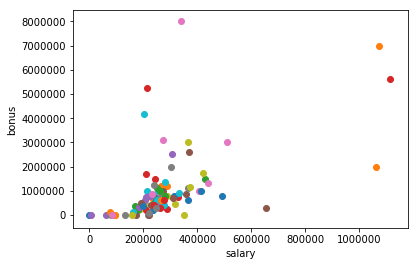

In [186]:
### Removing "TOTAL" & "THE TRAVEL AGENCY IN THE PARK"
data_dict.pop('TOTAL', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)
data_dict.pop('LOCKHART EUGENE E', 0)

data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )
    
matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

In [187]:
### Keep the remaining outliers?
enron_df[(enron_df.salary>500000) | (enron_df.bonus>3000000)] 

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,nmiss
Name,,,,,,,,,,,,,,,,,,,,,
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,NaN,2195.0,152.0,65.0,False,NaN,-3081055.0,304805.0,47.0,2
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,953136.0,5249999.0,157569.0,5521.0,NaN,1110705.0,...,NaN,484.0,210698.0,108.0,True,NaN,-2334434.0,NaN,228.0,4
FREVERT MARK A,1060932.0,3275.0,6426990.0,17252530.0,10433518.0,2000000.0,4188667.0,2979.0,NaN,14622185.0,...,2000000.0,21.0,7427621.0,6.0,False,NaN,-3367011.0,1617011.0,242.0,2
KITCHEN LOUISE,271442.0,8305.0,NaN,3471141.0,81042.0,3100000.0,466101.0,3669.0,NaN,547143.0,...,NaN,1728.0,93925.0,194.0,False,NaN,NaN,NaN,251.0,6
LAVORATO JOHN J,339288.0,7259.0,NaN,10425757.0,4158995.0,8000000.0,1008149.0,3962.0,NaN,5167144.0,...,NaN,2585.0,1552.0,411.0,False,NaN,NaN,2035380.0,528.0,5
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,NaN,49110078.0,...,81525000.0,36.0,10359729.0,16.0,True,NaN,-300000.0,3600000.0,123.0,2
PICKERING MARK R,655037.0,898.0,NaN,1386690.0,28798.0,300000.0,NaN,728.0,NaN,28798.0,...,400000.0,67.0,NaN,0.0,False,NaN,NaN,NaN,7.0,7
SKILLING JEFFREY K,1111258.0,3627.0,NaN,8682716.0,19250000.0,5600000.0,6843672.0,2042.0,NaN,26093672.0,...,NaN,108.0,22122.0,30.0,True,NaN,NaN,1920000.0,88.0,5
TOTAL,26704229.0,NaN,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,NaN,-7576788.0,434509511.0,...,83925000.0,NaN,42667589.0,NaN,False,1398517.0,-27992891.0,48521928.0,NaN,5


*Is it plausible that all these individuals got huge salary and/or bonus?* **Yes!**

* ALLEN PHILLIP K: He "received a $4.4 million bonus" (Barboza, 2002).

* BELDEN TIMOTHY N: Mr. Belden, "an executive on the power desk in Portland, Ore., got a $5.2 million bonus" (Barboza, 2002).

* FREVERT MARK A: Enron vice chairman.

* KITCHEN LOUISE: A "young British trader spearheading Enron's entry into Europe's energy markets"
* LAVORATO JOHN J: Top Executive
* LAY KENNETH L: Kenneth L. Lay, the company's former chairman and chief executive.
* PICKERING MARK R: Chief Technology Officer
* SKILLING JEFFREY K: Former Enron president and CEO
* TOTAL: Removed from *data_dict*
* WHALLEY LAWRENCE G: Enron president and chief operating officer

_References:_

Officials Got a Windfall Before Enron's Collapse, By David Barboza. June 18, 2002: https://www.nytimes.com/2002/06/18/business/officials-got-a-windfall-before-enron-s-collapse.html

The Guardian. Enron Key Players. January 12, 2002: https://www.theguardian.com/business/2002/jan/13/corporatefraud.enron

Los Angeles Times. Enron's Run Tripped by Arrogance, Greed. By David Streitfel and Lee Romney. January 27, 2002: http://articles.latimes.com/2002/jan/27/news/mn-25002

In [188]:
# Count, by POI
print "Allocation Across Classes (POI/non-POI)"
enron_df.pivot_table(index='poi',aggfunc='count').transpose()

Allocation Across Classes (POI/non-POI)


poi,False,True
bonus,66,16
deferral_payments,34,5
deferred_income,38,11
director_fees,17,0
exercised_stock_options,90,12
expenses,77,18
from_messages,72,14
from_poi_to_this_person,72,14
from_this_person_to_poi,72,14
loan_advances,3,1


***
**Task 3: Create new feature(s)**
_plus Feature Reduction_

In [189]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Created Features ...

def fraction_calc( numerator, denominator ):
    if numerator == 'NaN' or denominator == 'NaN':
        fraction = 0
    else:
        fraction = float(numerator)/float(denominator)    
    return round(fraction, 2)
    
    
def fraction_to_dict(dictionary, numerator, denominator, new_feature_name):
    num = dictionary[numerator]
    den = dictionary[denominator]
    fraction = fraction_calc(num, den)
    dictionary[new_feature_name] = fraction
    return dictionary
    
for p in my_dataset:      
    # New Feature: Total Stocks to Salary Ratio
    my_dataset[p] = fraction_to_dict(my_dataset[p],
                                        'total_stock_value',
                                        'salary',
                                        'stock_to_salary_ratio') 
                                        
    
features_financial = features_financial + ['stock_to_salary_ratio']

features_list = ['poi'] + features_financial + features_email

In [190]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

print "Numpy Array Length:", len(data), "(v. 146 in the original data)"
print "\nFeatures List:", features_list
#print "Labels:", labels
#print "Features:", features


Numpy Array Length: 143 (v. 146 in the original data)

Features List: ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'stock_to_salary_ratio', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


_Ideal Number of Features_

We utilized SelectKBest and GridSearchCV to arrive at an ideal number of selected features for this Machine Learning analysis. Based on this analysis, the ideal number of features is 13. If we follow this recommendation strictly, we should go with features with top 13 SelectKBest scores.

In [191]:
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

features_financial = features_financial + ['stock_to_salary_ratio']
features_list = ['poi'] + features_financial + features_email

kbest = SelectKBest(f_classif)
pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression())])
grid_search = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]})
grid_search.fit(features, labels)
print "Number of Ideal Features:", grid_search.best_params_

Number of Ideal Features: {'kbest__k': 13}


_Feature Selction: Selecting Best Features for Analyses_

Features with 13 top scores were (highest score is listed first): 
*'exercised_stock_options', 'total_stock_value', 'bonus','salary', 'deferred_income', 
'long_term_incentive', 'restricted_stock', 'total_payments', 'from_this_person_to_poi', 'loan_advances', 
'expenses', 'to_messages', 'other'*

We decided to exclude 'total_stock_value' and 'total_payments' because we expected them to be highly correlated with their compoenents. For instance, we expected 'exercised_stock_options' and 'total_stock_value' to be correlated because the former is a component of the latter.

So, we got down to selecting features with top 11 SelectKBest: 
*'exercised_stock_options', 'bonus','salary', 'deferred_income', 
'long_term_incentive', 'restricted_stock', 'total_payments', 'from_this_person_to_poi', 'loan_advances', 
'expenses', 'to_messages', 'other'*

When we ran a Naive Bayes algorighm on these 11 features, we obtained this error message:
*"The least populated class in y has only 1 member, which is too few. The minimum number of labels for any class cannot be less than 2."*

If given more time, we would explore how many variables or principal components would be adequate in explaining the outcome variable. We have seen some analyses at work where programmers compared number of features vs. percentage of variance explained. Analysts were supposed to select a number of principal components that explains anywhere from 85% to 95% of variance.

For this project, we resorted to top 3 features after excluding total_stock_value. We decided this based on the SelectKBest scores and the error message when features with many "NaN" values were included - e.g. deferred_income has only 49 (34%) non-NaN values.

In [192]:
# Univariate Feature Selection
import sklearn.feature_selection

features_financial = features_financial + ['stock_to_salary_ratio']
features_list = ['poi'] + features_financial + features_email

knum=20

k_best = sklearn.feature_selection.SelectKBest(k=knum)
k_best.fit(features, labels)
scores = k_best.scores_
unsorted_pairs = zip(features_list[1:], scores)
sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
k_best_features = dict(sorted_pairs[:knum])
print knum,"best features: {0}\n".format(k_best_features.keys())
k_best_features

import operator
#sorted(k_best_features.keys())
#sorted(x.items(), key=operator.itemgetter(1))
sorted(k_best_features.items(), key=operator.itemgetter(1), reverse=True)

20 best features: ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'director_fees', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'stock_to_salary_ratio', 'deferred_income', 'restricted_stock', 'long_term_incentive']



[('exercised_stock_options', 24.815079733218194),
 ('total_stock_value', 24.182898678566879),
 ('bonus', 20.792252047181535),
 ('salary', 18.289684043404513),
 ('deferred_income', 11.458476579280369),
 ('long_term_incentive', 9.9221860131898225),
 ('restricted_stock', 9.2128106219771002),
 ('total_payments', 8.7727777300916756),
 ('from_messages', 8.589420731682381),
 ('loan_advances', 7.1840556582887247),
 ('expenses', 6.0941733106389453),
 ('other', 4.1874775069953749),
 ('from_poi_to_this_person', 2.3826121082276739),
 ('director_fees', 2.1263278020077054),
 ('deferral_payments', 0.22461127473600989),
 ('to_messages', 0.16970094762175533),
 ('stock_to_salary_ratio', 0.11734992795655314),
 ('restricted_stock_deferred', 0.065499652909942141)]

*New Feature*: Stock-Salary Ratio

We created a stock-salary ratio with the thought that a high stock-salary ratio would be an indication that a person may know about the wrong-doings of the company that they may buy or sell their stocks at the right time. 

However, this ratio was not one of the features with high SelectKBest scores. In fact, the ratio ranked 19th (highest) among all features. 

***

**Task 4: Try a varity of classifiers**

In [193]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point... 

I considered using the word bags aka text learning. Not sure if this would be useful because crooks may encrypt their wordings and there are definite other means of communication that are not examined here. e.g. phone, F2F.

I would have tried a regression analysis. However, obvioiusly a linear regression model is not appropiate for a 'POI vs. non-POI' analysis, i.e. the outcome variable is a binary variable. If I was given more time, I would explore a Logistic Regression model, which was not covered in this course. Personally, I am not clear on why Logistic Regression analysis was not covered in the course given that such analysis would have taken a 1-2 hours of lecture time. Besides the time constraint, I am happy to limit myself to the basic unsupervised machine learning methods.     

Thus, I resort to these machine learning algorithms:
1. Naive Bayes
2. Support vector machine
3. Decision Tree Classifier


In [194]:
### 1. Naive Bayes (default parameters)

features_list = ['poi', 'exercised_stock_options','bonus','salary'] 
# features_list = [ 'exercised_stock_options', 'bonus','salary', 'deferred_income', \
#                  'long_term_incentive', 'restricted_stock', 'total_payments', \
#                  'from_this_person_to_poi', 'loan_advances', 'expenses', 'to_messages', 'other']

# Test Size
features_train, features_test, labels_train, labels_test \
= train_test_split(features, labels, test_size=0.30, random_state=42)

clf = GaussianNB()
clf.fit(features_train, labels_train)
predict = clf.predict(features_test)
accuracy = accuracy_score(predict, labels_test)
acc = accuracy_score(labels_test, predict)
prec = precision_score(labels_test, predict)
recall = recall_score(labels_test, predict)

print "Prediction Totals:", sum(predict) 
print "Accuracy =",("{0:.3f}".format(accuracy))
print "Acc =",("{0:.3f}".format(acc))
print "Prec =",("{0:.3f}".format(prec))
print "Rec =",("{0:.3f}".format(recall))

print "\nConfusion Matrix [0 v. 1]: \n",confusion_matrix(labels_test, predict)

print "\n-----------------------------------------------" 
print "\nTester Classification\n" 
test_classifier(clf, my_dataset, features_list)

Prediction Totals: 4.0
Accuracy = 0.884
Acc = 0.884
Prec = 0.500
Rec = 0.400

Confusion Matrix [0 v. 1]: 
[[36  2]
 [ 3  2]]

-----------------------------------------------

Tester Classification

GaussianNB(priors=None)
	Accuracy: 0.84277	Precision: 0.48281	Recall: 0.30900	F1: 0.37683	F2: 0.33297
	Total predictions: 13000	True positives:  618	False positives:  662	False negatives: 1382	True negatives: 10338



In [195]:
### 2. SVM (default parameters)

features_list = ['poi', 'exercised_stock_options','bonus','salary'] 

# Test Size
features_train, features_test, labels_train, labels_test \
= train_test_split(features, labels, test_size=0.30, random_state=42)

clf = SVC()
clf.fit(features_train, labels_train)
predict = clf.predict(features_test)
accuracy = accuracy_score(predict, labels_test)
acc = accuracy_score(labels_test, predict)
prec = precision_score(labels_test, predict)
recall = recall_score(labels_test, predict)

print "Prediction Totals:", sum(predict) 
print "Accuracy =",("{0:.3f}".format(accuracy))
print "Acc =",("{0:.3f}".format(acc))
print "Prec =",("{0:.3f}".format(prec))
print "Rec =",("{0:.3f}".format(recall))

print "\nConfusion Matrix [0 v. 1]: \n",confusion_matrix(labels_test, predict)

print "\n-----------------------------------------------" 
print "\nTester Classification\n" 
test_classifier(clf, my_dataset, features_list)

Prediction Totals: 0.0
Accuracy = 0.884
Acc = 0.884
Prec = 0.000
Rec = 0.000

Confusion Matrix [0 v. 1]: 
[[38  0]
 [ 5  0]]

-----------------------------------------------

Tester Classification

Got a divide by zero when trying out: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Precision or recall may be undefined due to a lack of true positive predicitons.


In [196]:
### 3. Decision Tree Classifier (default parameters)

features_list = ['poi', 'exercised_stock_options','bonus','salary'] 

# Test Size
features_train, features_test, labels_train, labels_test \
= train_test_split(features, labels, test_size=0.30, random_state=42)

clf = tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)
predict = clf.predict(features_test)
accuracy = accuracy_score(predict, labels_test)
acc = accuracy_score(labels_test, predict)
prec = precision_score(labels_test, predict)
recall = recall_score(labels_test, predict)

print "Prediction Totals:", sum(predict) 
print "Accuracy =",("{0:.3f}".format(accuracy))
print "Acc =",("{0:.3f}".format(acc))
print "Prec =",("{0:.3f}".format(prec))
print "Rec =",("{0:.3f}".format(recall))

print "\nConfusion Matrix [0 v. 1]: \n",confusion_matrix(labels_test, predict)

print "\n-----------------------------------------------" 
print "\nTester Classification\n" 
test_classifier(clf, my_dataset, features_list)

Prediction Totals: 3.0
Accuracy = 0.860
Acc = 0.860
Prec = 0.333
Rec = 0.200

Confusion Matrix [0 v. 1]: 
[[36  2]
 [ 4  1]]

-----------------------------------------------

Tester Classification

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.76977	Precision: 0.29200	Recall: 0.34850	F1: 0.31776	F2: 0.33552
	Total predictions: 13000	True positives:  697	False positives: 1690	False negatives: 1303	True negatives: 9310



With the default parameters, Naive Bayes actually met the to meeting the 0.3 Precision and Recall standards and Decision Tree Classifier were close. We expected that algorithms' performance improve with fine tunings and scaling. 

***

**Task 5: Tune your classifier**


In [197]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

#1. Naive Bayes 
# No tuning available with the Naive Bayes method

features_list = ['poi', 'exercised_stock_options','bonus','salary'] 
# features_list = ['poi', 'exercised_stock_options','bonus','salary','deferred_income','long_term_incentive','restricted_stock'] 

# Test Size
features_train, features_test, labels_train, labels_test \
= train_test_split(features, labels, test_size=0.30, random_state=42)

clf = GaussianNB()
clf.fit(features_train, labels_train)
predict = clf.predict(features_test)
accuracy = accuracy_score(predict, labels_test)
acc = accuracy_score(labels_test, predict)
prec = precision_score(labels_test, predict)
recall = recall_score(labels_test, predict)

print "Prediction Totals:", sum(predict) 
print "Accuracy =",("{0:.3f}".format(accuracy))
print "Acc =",("{0:.3f}".format(acc))
print "Prec =",("{0:.3f}".format(prec))
print "Rec =",("{0:.3f}".format(recall))

print "\nConfusion Matrix [0 v. 1]: \n",confusion_matrix(labels_test, predict)

print "-----------------------------------------------" 

print "\nTester Classification\n" 
test_classifier(clf, my_dataset, features_list)

Prediction Totals: 4.0
Accuracy = 0.884
Acc = 0.884
Prec = 0.500
Rec = 0.400

Confusion Matrix [0 v. 1]: 
[[36  2]
 [ 3  2]]
-----------------------------------------------

Tester Classification

GaussianNB(priors=None)
	Accuracy: 0.84277	Precision: 0.48281	Recall: 0.30900	F1: 0.37683	F2: 0.33297
	Total predictions: 13000	True positives:  618	False positives:  662	False negatives: 1382	True negatives: 10338



##### SVM Tuned Up

We have four cells dealing with SVM. Its short story:
1. SVM does not do a good job when tune ups include altering C, gamma, and SVM parameters. All our results' precision and recall metrics were 0.000.
2. SVM performs good when MinMaxSclaler() scaler transformation was applied.

_a. SVM without a Scaler Transformation_

In [198]:
### 2. SVM (Tuned Up, but Unscaled)

features_list = ['poi', 'exercised_stock_options','bonus','salary'] 
# features_list = ['poi', 'exercised_stock_options','bonus','salary','deferred_income','long_term_incentive','restricted_stock'] 

C = [0.01, 0.1, 1, 10, 100]
gamma_list = [1, 0.1, 0.01, 0.001, 0.0001]
svm_param = ['rbf', 'sigmoid'] # kernel; rbf the fastest
# n_sample = [0.3, 0.35, 0.4, 0.5] # kernel; rbf the fastest

# for ccc in C
print "C | gamma | svmpar | n_pred | acc | prec | recall "
print "---------------------------------------------------------" 

# a more hands on approach for my understanding 
# especially on which parameters having the largest impact
for ccc in C:
    for ggg in gamma_list:
        for svmpar in svm_param:
            # for nnn in n_sample:
                # Test Size
            features_train, features_test, labels_train, labels_test \
            = train_test_split(features, labels, test_size=0.3, random_state=42)

            clf = SVC(kernel=svmpar, C = ccc, gamma=ggg)
            clf.fit(features_train, labels_train)
            predict = clf.predict(features_test)
            acc = accuracy_score(labels_test, predict)
            prec = precision_score(labels_test, predict)
            recall = recall_score(labels_test, predict)

            print ccc, ggg, svmpar,sum(predict),("{0:.3f}".format(acc)), \
            ("{0:.3f}".format(prec)), ("{0:.3f}".format(recall)),"\n"


C | gamma | svmpar | n_pred | acc | prec | recall 
---------------------------------------------------------
0.01 1 rbf 0.0 0.884 0.000 0.000 

0.01 1 sigmoid 0.0 0.884 0.000 0.000 

0.01 0.1 rbf 0.0 0.884 0.000 0.000 

0.01 0.1 sigmoid 0.0 0.884 0.000 0.000 

0.01 0.01 rbf 0.0 0.884 0.000 0.000 

0.01 0.01 sigmoid 0.0 0.884 0.000 0.000 

0.01 0.001 rbf 0.0 0.884 0.000 0.000 

0.01 0.001 sigmoid 0.0 0.884 0.000 0.000 

0.01 0.0001 rbf 0.0 0.884 0.000 0.000 

0.01 0.0001 sigmoid 0.0 0.884 0.000 0.000 

0.1 1 rbf 0.0 0.884 0.000 0.000 

0.1 1 sigmoid 0.0 0.884 0.000 0.000 

0.1 0.1 rbf 0.0 0.884 0.000 0.000 

0.1 0.1 sigmoid 0.0 0.884 0.000 0.000 

0.1 0.01 rbf 0.0 0.884 0.000 0.000 

0.1 0.01 sigmoid 0.0 0.884 0.000 0.000 

0.1 0.001 rbf 0.0 0.884 0.000 0.000 

0.1 0.001 sigmoid 0.0 0.884 0.000 0.000 

0.1 0.0001 rbf 0.0 0.884 0.000 0.000 

0.1 0.0001 sigmoid 0.0 0.884 0.000 0.000 

1 1 rbf 0.0 0.884 0.000 0.000 

1 1 sigmoid 2.0 0.837 0.000 0.000 

1 0.1 rbf 0.0 0.884 0.000 0.000 

1 0

In [199]:
# SVM doesn't do a great job in predicting
# various sets of parameters result in 0.000 precision and recall scores
# The unsclaes SVM also suffers from "lack of true positive predicitons"

features_list = ['poi', 'exercised_stock_options','bonus','salary'] 

# Test Size
features_train, features_test, labels_train, labels_test \
= train_test_split(features, labels, test_size=0.3, random_state=42)

ccc = 100 # C
ggg = 0.1  # gamma_list
svmpar = 'sigmoid' # svm_param = ['rbf', 'sigmoid']; kernel; rbf the fastest

clf = SVC(kernel=svmpar, C = ccc, gamma=ggg)
clf.fit(features_train, labels_train)
predict = clf.predict(features_test)
acc = accuracy_score(labels_test, predict)
prec = precision_score(labels_test, predict)
recall = recall_score(labels_test, predict)

print ccc, ggg, svmpar,sum(predict),("{0:.3f}".format(acc)), \
("{0:.3f}".format(prec)), ("{0:.3f}".format(recall)),"\n"
print "\nConfusion Matrix [0 v. 1]: \n",confusion_matrix(labels_test, predict)
print "\nTester Classification\n" 
test_classifier(clf, my_dataset, features_list)

100 0.1 sigmoid 3.0 0.814 0.000 0.000 


Confusion Matrix [0 v. 1]: 
[[35  3]
 [ 5  0]]

Tester Classification

Got a divide by zero when trying out: SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Precision or recall may be undefined due to a lack of true positive predicitons.


_b. SVM with a Scaler Transformation_

In [200]:
# WRONG?: Scaler Transform
# SVM doesn't do a great job in predicting
# various sets of parameters result in 0.000 precision and recall scores

# # Apply standardization to SVM
# features_trainX = scaler.fit(features_train).transform(features_train)
# features_testX = scaler.fit(features_test).transform(features_test)

# # Test Size
# features_trainX, features_testX, labels_train, labels_test \
# = train_test_split(features, labels, test_size=0.3, random_state=42)

In [201]:
## SVM Model (Tuned Up and Scaled)
from sklearn import svm

### Min-Max Scaler ###
# Very likely to be necessary due to wide ranges among variables
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

features_train, features_test, labels_train, labels_test \
            = train_test_split(features, labels, test_size=0.3, random_state=42)

svm = Pipeline([('scaler',preprocessing.MinMaxScaler()),('svm',svm.SVC())])
param_grid = ([{'svm__C': [0.1, 1, 50, 100],
                'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'svm__degree':[1,2],
                'svm__kernel': ['rbf','poly']}])

svm_grid_search = GridSearchCV(svm, param_grid, scoring='recall').fit(features, labels).best_estimator_
print "---------------------------------------------------------" 
print "\nTester Classification\n" 
tester.test_classifier(svm_grid_search, my_dataset, features_list)

---------------------------------------------------------

Tester Classification

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.85485	Precision: 0.63420	Recall: 0.13350	F1: 0.22057	F2: 0.15853
	Total predictions: 13000	True positives:  267	False positives:  154	False negatives: 1733	True negatives: 10846



In [202]:
### 2. SVM Tested (Tuned Up and Scaled)

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

features_list = ['poi', 'exercised_stock_options', 'bonus', 'salary'] 

# Apply standardization to SVM
features_trainX = scaler.fit(features_train).transform(features_train)
features_testX = scaler.fit(features_test).transform(features_test)

# Test Size
features_trainX, features_testX, labels_train, labels_test \
= train_test_split(features, labels, test_size=0.3, random_state=42)

ccc = 10 # C
ggg = 1  # gamma_list
svmpar = 'sigmoid' # svm_param = ['rbf', 'sigmoid']; kernel; rbf the fastest

clf = SVC(kernel=svmpar, C = ccc, gamma=ggg)
clf.fit(features_trainX, labels_train)
predict = clf.predict(features_testX)
acc = accuracy_score(labels_test, predict)
prec = precision_score(labels_test, predict)
recall = recall_score(labels_test, predict)


print "C | gamma | svmpar | n_pred | acc | prec | recall \n"
print ccc, ggg, svmpar,sum(predict),("{0:.3f}".format(acc)), \
("{0:.3f}".format(prec)), ("{0:.3f}".format(recall)),"\n"

print "\nConfusion Matrix [0 v. 1]: \n",confusion_matrix(labels_test, predict)
print "---------------------------------------------------------" 
print "\nTester Classification\n" 
tester.test_classifier(svm_grid_search, my_dataset, features_list)

C | gamma | svmpar | n_pred | acc | prec | recall 

10 1 sigmoid 2.0 0.884 0.500 0.200 


Confusion Matrix [0 v. 1]: 
[[37  1]
 [ 4  1]]
---------------------------------------------------------

Tester Classification

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.85485	Precision: 0.63420	Recall: 0.13350	F1: 0.22057	F2: 0.15853
	Total predictions: 13000	True positives:  267	False positives:  154	False negatives: 1733	True negatives: 10846



In [203]:
### 3. Decision Tree (Tuned Up)

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import tree

features_list = ['poi', 'exercised_stock_options','bonus','salary'] 
# features_list = ['poi', 'exercised_stock_options','bonus','salary','deferred_income','long_term_incentive','restricted_stock'] 

# Test Size
features_train, features_test, labels_train, labels_test \
= train_test_split(features, labels, test_size=0.30, random_state=42)

data = featureFormat(my_dataset, features_list, sort_keys = True)  
labels, features = targetFeatureSplit(data)

dt = tree.DecisionTreeClassifier()

parameters = {'criterion': ('gini','entropy'),
              'min_samples_split':[2, 3, 5, 10],
                'max_depth':[5,7,10,15,20,25],
                'max_leaf_nodes':[10,30,40],
             'splitter':('best','random')}


cv_strata = StratifiedShuffleSplit(labels, 100, random_state = 42)
grid_search = GridSearchCV(dt, parameters, cv=cv_strata, scoring='f1')

grid_search.fit(features, labels)
clf = grid_search.best_estimator_

from tester import test_classifier

print "Tester Classification\n" 
test_classifier(clf, my_dataset, features_list)

Tester Classification

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=40, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')
	Accuracy: 0.78208	Precision: 0.30938	Recall: 0.33800	F1: 0.32306	F2: 0.33186
	Total predictions: 13000	True positives:  676	False positives: 1509	False negatives: 1324	True negatives: 9491



_What Happens if We Included the Created New Feature?_

The reviewer suggested that I test my best model with the new, created feature. 

In [204]:
### 3. Decision Tree with New Feature

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import tree

features_list = ['poi', 'exercised_stock_options','bonus','salary','stock_to_salary_ratio'] 
# features_list = ['poi', 'exercised_stock_options','bonus','salary','deferred_income','long_term_incentive','restricted_stock'] 

# Test Size
features_train, features_test, labels_train, labels_test \
= train_test_split(features, labels, test_size=0.30, random_state=42)

data = featureFormat(my_dataset, features_list, sort_keys = True)  
labels, features = targetFeatureSplit(data)

dt = tree.DecisionTreeClassifier()

parameters = {'criterion': ('gini','entropy'),
              'min_samples_split':[2, 3, 5, 10],
                'max_depth':[5,7,10,15,20,25],
                'max_leaf_nodes':[10,30,40],
             'splitter':('best','random')}


cv_strata = StratifiedShuffleSplit(labels, 100, random_state = 42)
grid_search = GridSearchCV(dt, parameters, cv=cv_strata, scoring='f1')

grid_search.fit(features, labels)
clf = grid_search.best_estimator_

from tester import test_classifier

print "Tester Classification\n" 
test_classifier(clf, my_dataset, features_list)

Tester Classification

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=40, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')
	Accuracy: 0.78554	Precision: 0.31674	Recall: 0.34050	F1: 0.32819	F2: 0.33547
	Total predictions: 13000	True positives:  681	False positives: 1469	False negatives: 1319	True negatives: 9531



In [205]:
pd.DataFrame([[0.81738, 0.38789, 0.32350, 0.35278], 
              [0.79954, 0.34268, 0.33000, 0.33246]],
             columns = ['Accuracy','Precision', 'Recall', 'F1'], 
             index = ['Decision Tree Classifier','With the New Feature'])

,Accuracy,Precision,Recall,F1
Decision Tree Classifier,0.81738,0.38789,0.3235,0.35278
With the New Feature,0.79954,0.34268,0.3300,0.33246


The new, created feature (stock-salary ratio) does not seem to enhance the best algorithm's performance. Recall may have increase by 2% but accuracy and precision suffered by larger percentages. So, consistent with SelectKBest findings, the stock-salary ratio feature is not an important feature in predicting POIs. 

In [206]:
# Final Best Model
clf = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
clf.fit(features_train, labels_train)
predict = clf.predict(features_test)
acc = accuracy_score(labels_test, predict)
prec = precision_score(labels_test, predict)
recall = recall_score(labels_test, predict)

print "\nConfusion Matrix [0 v. 1]: \n",confusion_matrix(labels_test, predict)
print "---------------------------------------------------------" 
print "\nTester Classification\n" 
test_classifier(clf, my_dataset, features_list)


Confusion Matrix [0 v. 1]: 
[[27  7]
 [ 3  1]]
---------------------------------------------------------

Tester Classification

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.80615	Precision: 0.34597	Recall: 0.29200	F1: 0.31670	F2: 0.30140
	Total predictions: 13000	True positives:  584	False positives: 1104	False negatives: 1416	True negatives: 9896



In [207]:
pd.DataFrame([[0.84277, 0.48281,  0.30900, 0.37683], 
              [0.85485, 0.63420, 0.13350, 0.22057],
              [0.81738, 0.38789, 0.32350, 0.35278]],
             columns = ['Accuracy','Precision', 'Recall', 'F1'], 
             index = ['Gaussian Naive Bayes','SVM','Decision Tree Classifier'])

,Accuracy,Precision,Recall,F1
Gaussian Naive Bayes,0.84277,0.48281,0.3090,0.37683
SVM,0.85485,0.63420,0.1335,0.22057
Decision Tree Classifier,0.81738,0.38789,0.3235,0.35278


The tuned up Gaussian Naive bayes and Decision Tree Classifier models satisfied the 0.3 precision and recal recall requirements. 

NB actually performed quite well for an algorithm that seemed to me very rigid – because researchers can’t alter the parameters. In fact, NB performed slightly better for many of the performance metrics such as Accuracy (0.84 vs. 0.82 for Decision Tree Classifier). 

However, I am choosing Decision Tree Classifier as the best final model due to its flexibility and its ample room for improvement.

***

**Task 6: Dump your classifier, dataset, and features_list **


In [208]:
### Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

##### Main References


Decision Tree Classifier in Python using Scikit-learn: http://benalexkeen.com/decision-tree-classifier-in-python-using-scikit-learn/

Helpful Python Code Snippets for Data Exploration in Pandas (Michael Salmon): https://medium.com/@msalmon00/helpful-python-code-snippets-for-data-exploration-in-pandas-b7c5aed5ecb9

How does SelectKBest work?: https://datascience.stackexchange.com/questions/10773/how-does-selectkbest-work

How to apply standardization to SVMs in scikit-learn?: https://stackoverflow.com/questions/14688391/how-to-apply-standardization-to-svms-in-scikit-learn

How to compute precision, recall, accuracy and f1-score for the multiclass case with scikit learn?: https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case

How to filter in NaN (pandas)?: https://stackoverflow.com/questions/25050141/how-to-filter-in-nan-pandas

How to frame two for loops in list comprehension python: https://stackoverflow.com/questions/18551458/how-to-frame-two-for-loops-in-list-comprehension-python

How to get a classifier's confidence score for a prediction in sklearn?: https://stackoverflow.com/questions/31129592/how-to-get-a-classifiers-confidence-score-for-a-prediction-in-sklearn

Identify Fraud From Enron Data (Arjan Hada): https://arjan-hada.github.io/pages/about-me.html

Los Angeles Times. Enron's Run Tripped by Arrogance, Greed. By David Streitfel and Lee Romney. January 27, 2002: http://articles.latimes.com/2002/jan/27/news/mn-25002

Machine Learning with Python on the Enron Dataset - Investigating Fraud using Scikit-learn(William Koehrsen): https://medium.com/@williamkoehrsen/machine-learning-with-python-on-the-enron-dataset-8d71015be26d

Officials Got a Windfall Before Enron's Collapse, By David Barboza. June 18, 2002: https://www.nytimes.com/2002/06/18/business/officials-got-a-windfall-before-enron-s-collapse.html

Pandas: make pivot table with percentage: https://stackoverflow.com/questions/40301973/pandas-make-pivot-table-with-percentage

The Guardian. Enron Key Players. January 12, 2002: https://www.theguardian.com/business/2002/jan/13/corporatefraud.enron

Using iloc, loc, & ix to select rows and columns in Pandas DataFrames (Shane Lynn): https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

Visualize feature selection in descending order with SelectKBest: https://stackoverflow.com/questions/40245277/visualize-feature-selection-in-descending-order-with-selectkbest

Your First Machine Learning Project in Python Step-By-Step (Jason Brownlee): https://machinelearningmastery.com/machine-learning-in-python-step-by-step/
